In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.932722,0.806913,0.653998,0.860533,0.837016,1.0,0.550415,0.000000,0.778617,0.940755
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.692339,0.578107,0.619998,0.0,0.000000,0.000000,0.607899,0.206271
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.000000,0.505180,0.644769,0.603195,0.756754,0.0,0.350566,0.000000,0.899508,0.014040
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.000000,0.000000,0.131632,0.053179,0.774455,0.0,0.000000,0.000000,0.528882,0.305806
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.000000,0.000000,0.085440,0.761822,0.860355,0.0,0.000000,0.000000,0.604102,0.014040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.000000,0.000000,0.149005,0.740343,0.641698,0.0,0.000000,0.694951,0.485461,0.300471
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.000000,0.000000,0.229358,0.640000,0.731908,0.0,0.422815,0.096205,0.502320,0.615334
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.000000,0.000000,0.211405,0.797333,0.896369,0.0,0.234352,0.000000,0.496177,0.402714


In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.00000,0.0,0.016890,0.754178,0.816832,0.0,0.214180,0.000000,0.627881,0.014040
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.00000,0.0,0.380373,0.659297,0.789071,0.0,0.000000,0.296100,0.763348,0.354178
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.68115,0.0,0.127947,1.009412,0.582660,0.0,0.000000,0.473139,0.277717,0.014040
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.00000,0.0,0.203518,0.723574,0.696147,0.0,0.000000,0.000000,0.646765,0.450394
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.00000,0.0,0.214416,0.496175,0.803259,0.0,0.236722,0.000000,0.534480,0.304870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.00000,0.0,0.357494,0.782257,0.591442,0.0,0.000000,0.431213,0.465159,0.540147
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.00000,0.0,0.418615,0.949858,0.559052,0.0,0.269991,0.410777,0.361163,0.561191
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.00000,0.0,0.105689,0.683222,0.878635,0.0,0.182111,0.650452,0.568842,0.398252


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('cd_clf')

In [7]:
# compound_model.summary()

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


link.f
link.f
link.f
link.f


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [14]:


with open("../data/models/shap/all_dep_2p11_2", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [15]:
shap_values = shap_values[0]


In [16]:
# for i in range(3):
#     shap_values[i] /= 100

In [17]:
shap_values

[array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
         -10.15900833,   8.16725687],
        [  4.67853497,  -5.04835038,  -3.91388581, ...,  -3.50943679,
          -2.99081171,   5.43148643],
        [ 11.3294224 ,   0.        ,   0.        , ..., -10.40619615,
           0.        ,   0.        ],
        ...,
        [  0.        ,   2.69663671,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  -1.64655816,   0.        , ...,  -3.88908344,
           3.77671009,   0.        ],
        [  0.        ,   0.        ,   3.27982631, ...,   0.        ,
           0.        ,   0.        ]]),
 array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  11.92810689,   0.        , ...,   0.        ,
           0.        ,  -8.24194014],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,


In [18]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 221)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [19]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.0,0.0,0.155668,0.723766,0.785738,0.0,0.0,0.236732,0.678505,0.727315


In [20]:
gmm_model_get_prediction_ae(patient)[0]

array([2.10208717e-56, 1.38514946e-01, 8.61485054e-01])

In [21]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.10208717e-56 1.38514946e-01 8.61485054e-01]
Predicted class: 2


#### Control

In [22]:
import shap

In [23]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [24]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [25]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [26]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

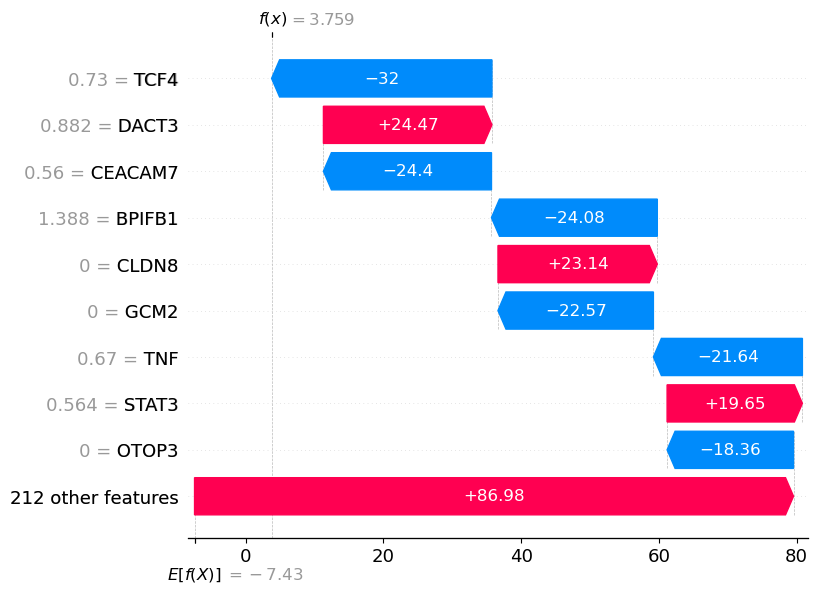

In [27]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [29]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [30]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

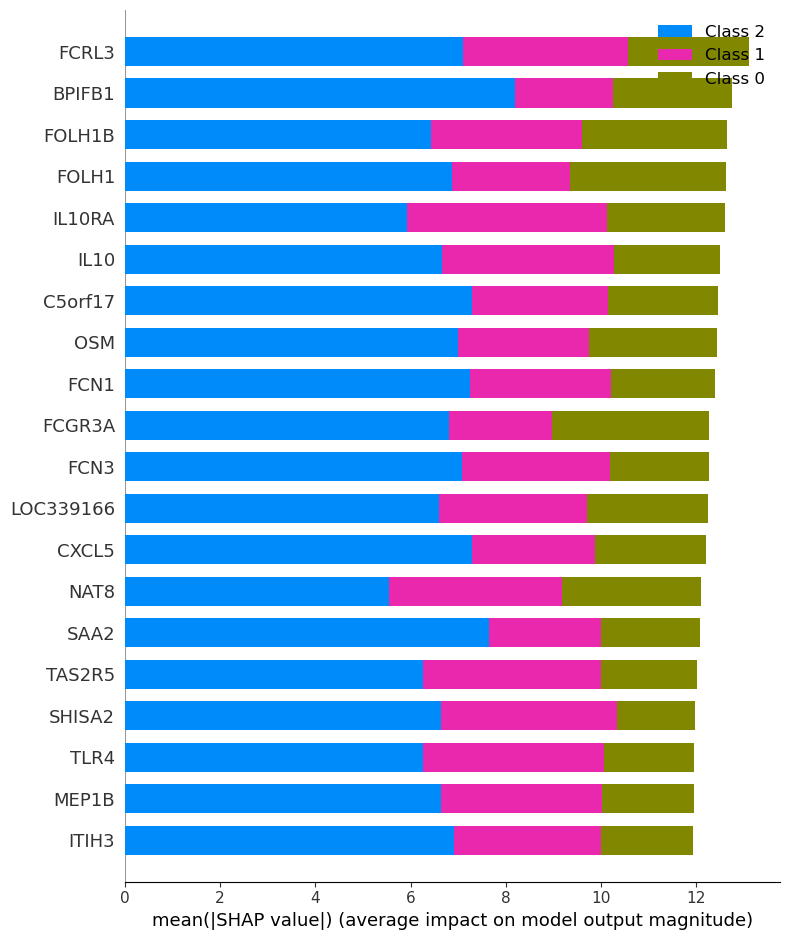

In [31]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


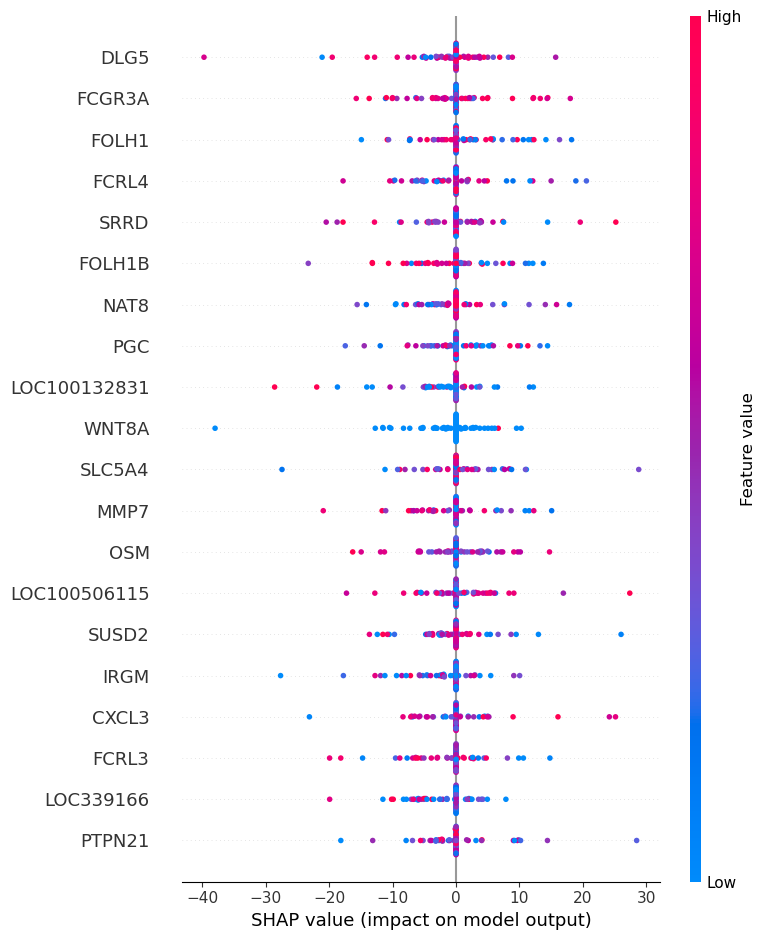

In [32]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

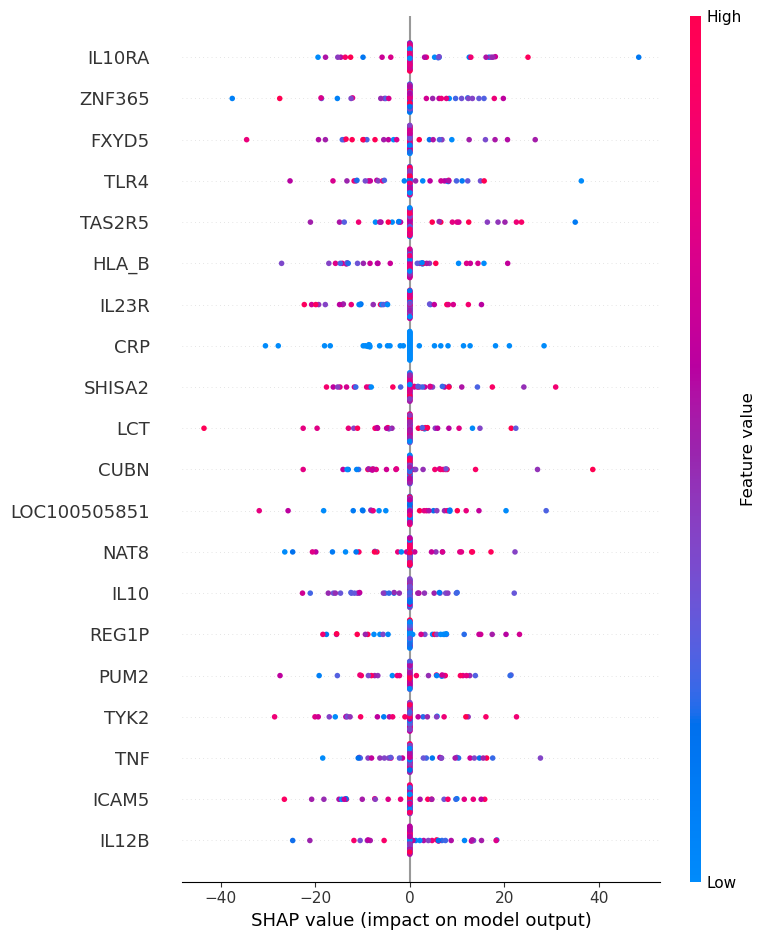

In [33]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

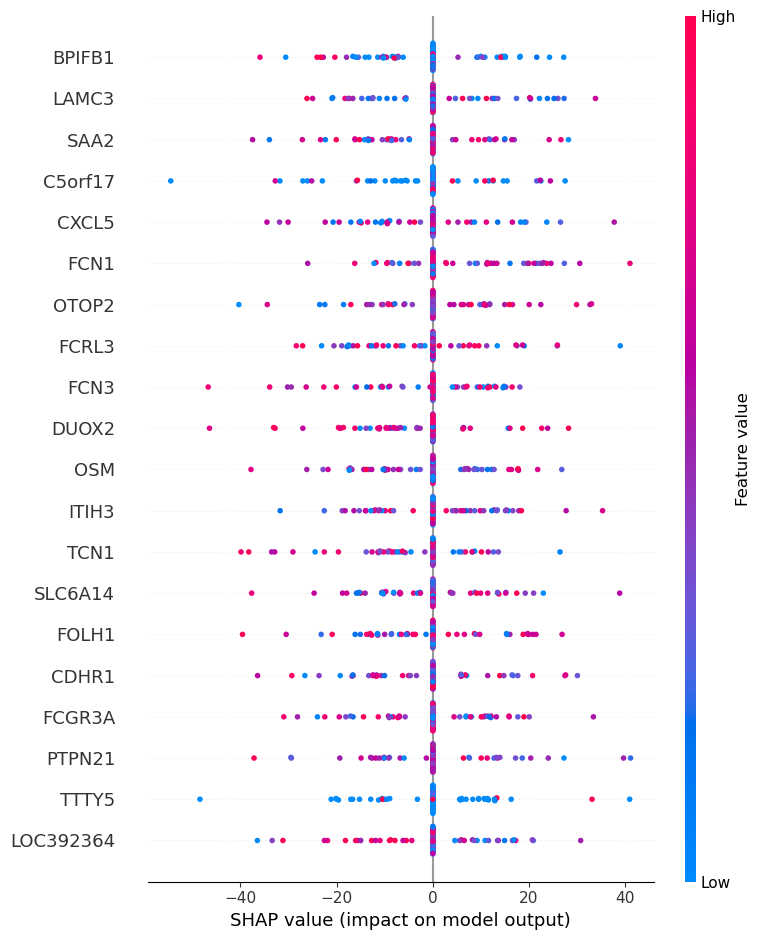

In [34]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

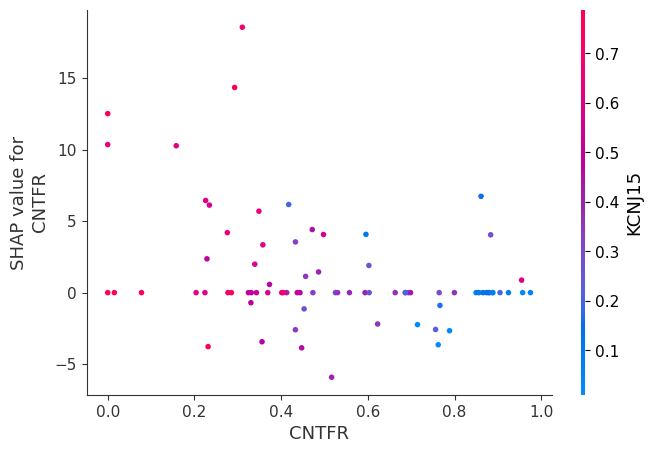

In [35]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

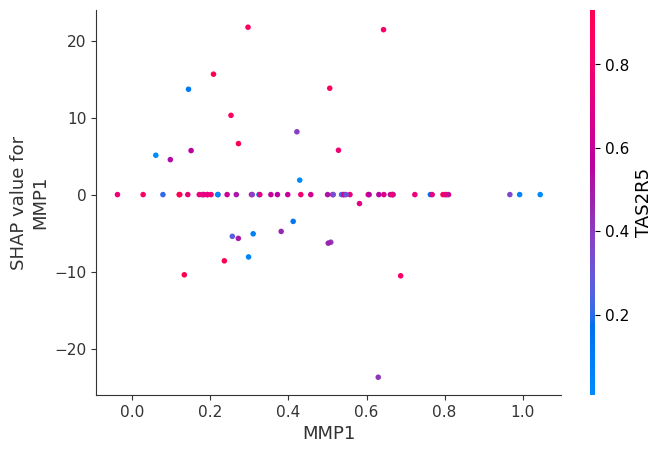

In [36]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

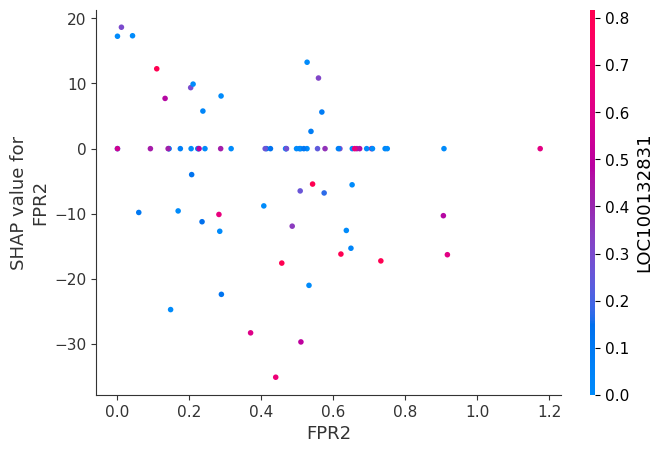

In [37]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [38]:
disease_labels_test.shape

(78,)

In [39]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [40]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 96%|█████████████████████████████████████████████████████████████████████████████   | 213/221 [01:26<00:02,  2.99it/s]No/low signal found from feature 212 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
222it [01:30,  2.19it/s]                                                                                               


In [41]:
# clustering

In [42]:
# clustering.shape

In [43]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [44]:
type(exp)

shap._explanation.Explanation

In [45]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [46]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

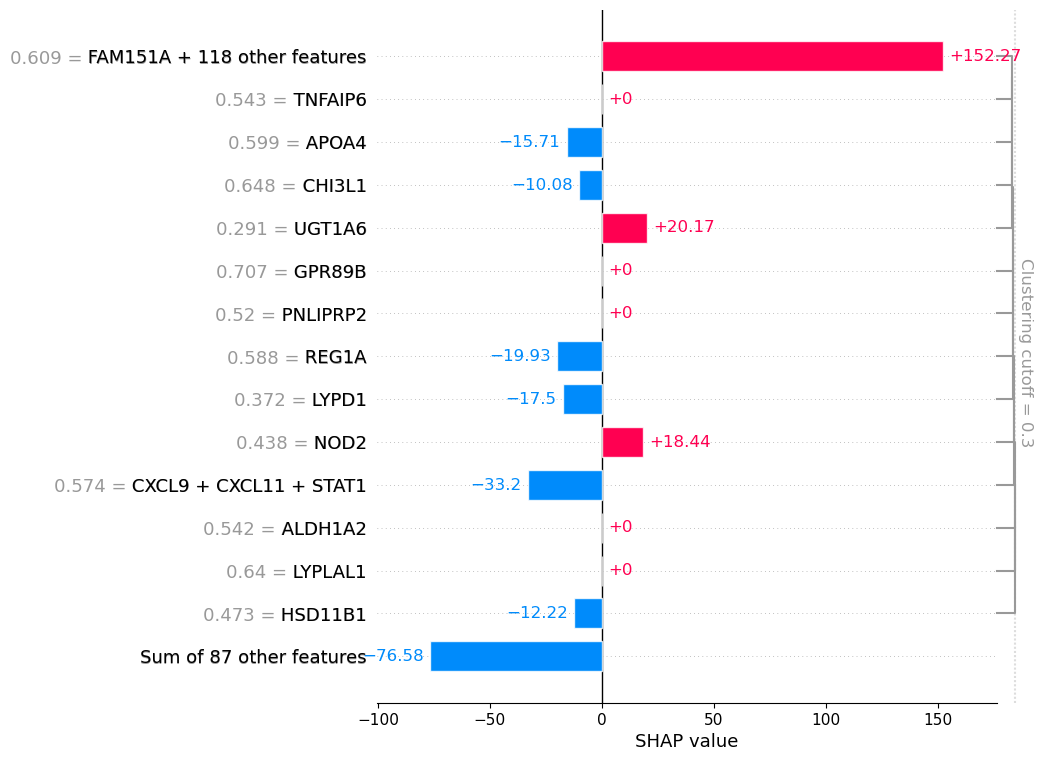

In [47]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [49]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.110663,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.510424
167_CD_deep_ulcer,0.000000,0.000000,0.000000,11.545179,0.000000,15.031488,-9.901804,0.000000,0.000000,-19.154371,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.573901,0.000000
196_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,-22.222357,-16.552244,0.000000,-23.127594,0.000000,12.170068,...,0.000000,0.000000,0.000000,0.000000,0.000000,16.979438,15.443975,8.536599,0.000000,17.814578
23_CD_deep_ulcer,0.000000,12.633051,9.094325,-15.756693,0.000000,0.000000,-3.686181,-5.959102,0.000000,0.000000,...,0.000000,0.000000,8.991422,0.000000,15.300076,7.693980,0.000000,0.000000,7.433222,-12.657653
93_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
229_CD_deep_ulcer,0.000000,0.000000,-21.425190,-13.792527,11.017550,6.599138,0.000000,-8.655641,0.000000,6.101970,...,0.000000,0.000000,0.000000,7.972930,6.016355,0.000000,0.000000,0.000000,8.535624,0.000000
46_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.404118,0.000000,0.000000,...,0.000000,16.056491,0.000000,-9.352086,7.321026,0.000000,0.000000,0.000000,0.000000,0.000000
176_CD_deep_ulcer,0.000000,0.000000,8.915009,-4.654037,0.000000,6.951624,0.000000,-8.633824,0.000000,0.000000,...,-6.734269,6.914442,0.000000,8.072781,0.000000,11.274690,9.003252,0.000000,10.695807,0.000000
49_CD_deep_ulcer,0.000000,-4.801211,-33.541444,11.912849,0.000000,-6.607858,-6.666427,0.000000,8.690765,0.000000,...,-3.610293,6.359092,0.000000,0.000000,-16.818725,0.000000,0.000000,0.000000,0.000000,0.000000


### Example: CD deep ulcer patients

In [50]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

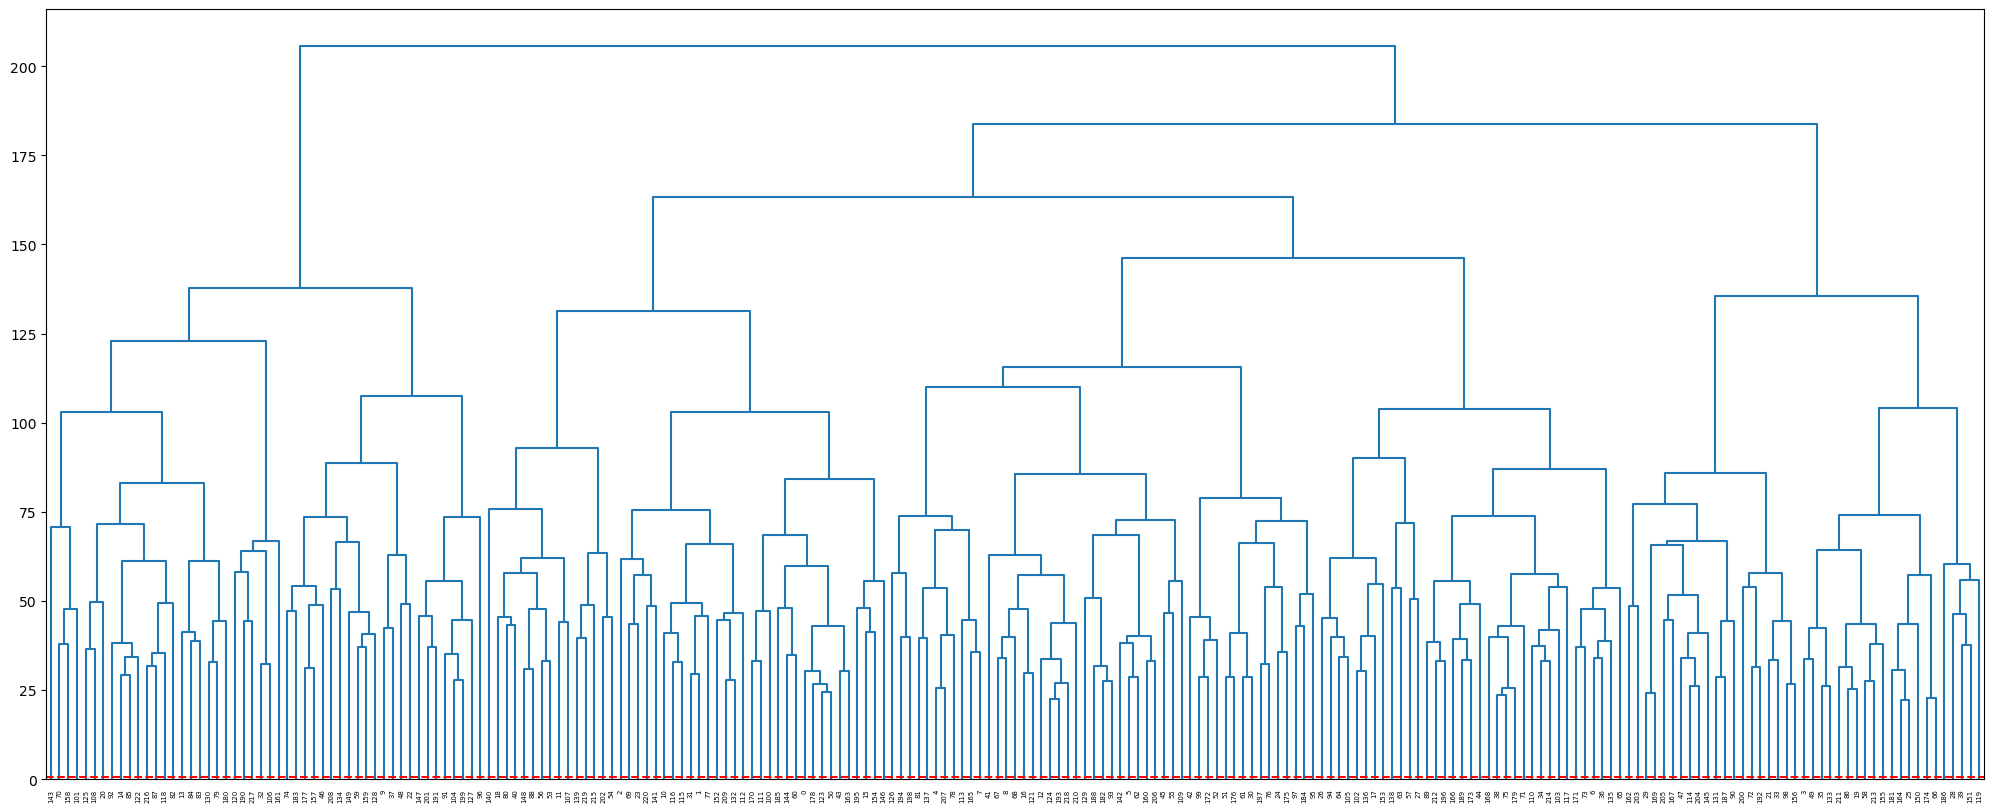

In [51]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [52]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([143,  70, 158, 101, 125, 108,  20,  92,  14,  85, 122, 216,  87,
       118,  82,  13,  84,  83, 130,  79, 180, 120, 190, 217,  32, 106,
       161,  74, 183, 177, 157,  46, 208, 134, 149,  59, 159, 128,   9,
        37,  48,  22, 147, 201, 191,  91, 104, 199, 127,  96, 140,  18,
        80,  40, 148,  88,  56,  53,  11, 107, 139, 219, 215, 202,  54,
         2,  69,  23, 220, 141,  10, 116, 115,  31,   1,  77, 152, 209,
       132, 112, 170, 111, 100, 185, 144,  60,   0, 178, 123,  50,  43,
       163, 195,  15, 154, 146, 126, 194, 198,  81, 137,   4, 207,  78,
       113, 165,   7,  41,  67,   8,  68,  16, 121,  12, 124, 193, 218,
       210, 129, 188, 182,  93, 142,   5,  62, 160, 206,  45,  55, 109,
        42,  99, 172,  52,  51, 176,  61,  30, 197,  76,  24, 175,  97,
       184,  95,  26,  94,  64, 105, 102, 136,  17, 153, 138,  63,  57,
        27,  89, 212, 196, 166, 189, 173,  44, 168,  38,  75, 179,  71,
       110,  34, 214, 103, 117, 171,  73,   6,  36, 135,  65, 16

In [53]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

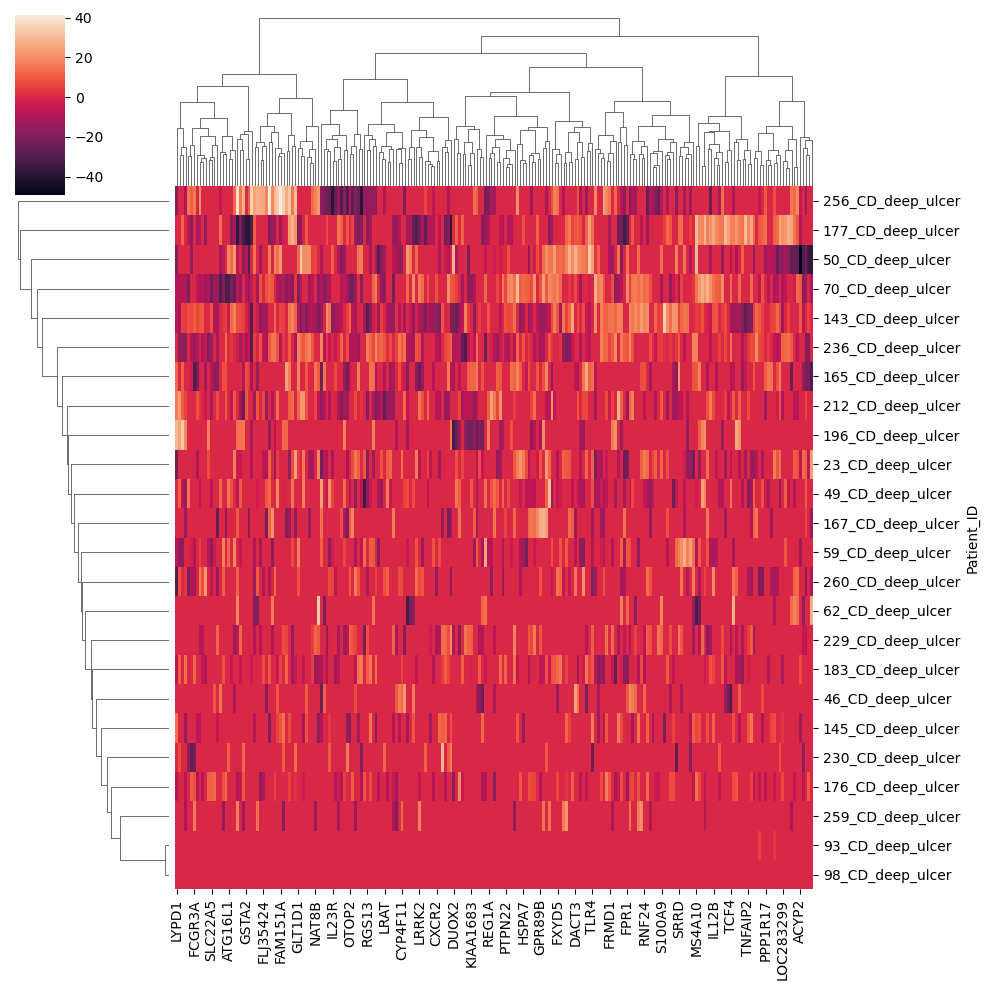

In [54]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [55]:
gene_cluster_cd_deep

array([[164.        ,  25.        ,  22.30041162,   2.        ],
       [124.        , 193.        ,  22.502986  ,   2.        ],
       [174.        ,  66.        ,  22.65460998,   2.        ],
       [ 38.        ,  75.        ,  23.65585368,   2.        ],
       [ 29.        , 169.        ,  24.17582442,   2.        ],
       [123.        ,  50.        ,  24.57355991,   2.        ],
       [ 86.        ,  19.        ,  25.36383789,   2.        ],
       [  4.        , 207.        ,  25.50702659,   2.        ],
       [224.        , 179.        ,  25.70680244,   3.        ],
       [ 35.        , 133.        ,  26.02157581,   2.        ],
       [114.        , 204.        ,  26.03132326,   2.        ],
       [178.        , 226.        ,  26.58817552,   3.        ],
       [ 98.        , 156.        ,  26.70325274,   2.        ],
       [222.        , 218.        ,  26.93439329,   3.        ],
       [182.        ,  93.        ,  27.41567745,   2.        ],
       [ 58.        , 213

In [56]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [57]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([ 70, 158, 101, 143, 125, 108,  20,  14,  85, 122,  92, 216,  87,
        118,  82,  84,  83,  13, 130,  79, 180, 190, 217, 120,  32, 106,
        161,  74, 183, 177, 157,  46, 208, 134,  59, 159, 128, 149,   9,
         37,  48,  22, 201, 191, 147, 104, 199,  91, 127,  96,  80,  40,
         18, 148,  88,  56,  53,  11, 107, 140, 139, 219, 215, 202,  54,
         69,  23, 220, 141,   2, 116, 115,  10,  31,   1,  77, 209, 132,
        152, 112, 170, 111, 100, 144,  60, 185, 123,  50, 178,   0,  43,
        163,  15, 154, 195, 146, 194, 198, 126,  81, 137,   4, 207,  78,
        165,   7, 113,  67,   8,  68,  16, 121, 124, 193, 218,  12, 210,
         41, 182,  93, 188, 129,   5,  62, 142, 160, 206,  45,  55, 109,
         99, 172,  52,  42,  51, 176,  61,  30, 197,  76,  24, 175,  97,
        184,  95,  64, 105,  94,  26, 102, 136,  17, 153, 138,  63,  57,
         27, 212, 196,  89, 189, 173, 166,  44,  38,  75, 179, 168,  71,
         34, 214, 110, 103, 117, 171,  73,   6,  36

In [58]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [59]:
cluster_labels

array([ 90,  75,  70, 201, 102, 123, 177, 106, 109,  39,  73,  58, 116,
        18,   8,  93, 111, 152,  53, 206,   7, 197,  42,  67, 141, 212,
       149, 157, 219, 183, 138,  74,  25, 198, 170, 203, 178,  40, 165,
       217,  52, 118, 134,  91, 164, 128,  32, 189,  41, 202,  88, 135,
       133,  57,  65, 129,  56, 156, 208,  35,  85, 137, 124, 155, 146,
       180, 216, 108, 110,  66,   1, 169, 194, 176,  28, 166, 140,  76,
       104,  20,  51, 100,  15,  17,  16,   9, 205,  13,  55, 160, 193,
        48,  11, 120, 148, 145,  50, 143, 199, 131,  83,   3, 150, 173,
        46, 147,  26,  59,   6, 130, 172,  82,  80, 107, 187,  72,  71,
       174,  14, 220,  24, 112,  10,  87, 113,   5,  99,  49,  37, 122,
        19, 191,  78, 204,  34, 179, 151, 101, 154,  61,  60,  69, 125,
         4,  84, 190,  96,  45,  54,  38, 214, 218,  79, 153,  94, 210,
       200,  31,   2,  36, 126,  27, 181,  92, 211, 105, 163, 186, 168,
       184,  81, 175, 132, 162, 215, 142, 136,  30,  89, 167,  2

In [60]:
df_cd_deep.columns.get_loc("OSM")

63

In [61]:
np.where(cluster_labels == 2) #osm

(array([158], dtype=int64),)

In [62]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,-1.215792,7.316295,-26.955353,0.000000,0.0,0.000000,11.144159,AADAC,90
APOA1,24.0,-1.010464,5.532506,-13.339899,0.000000,0.0,0.000000,12.633051,APOA1,75
APOA4,24.0,-2.192608,9.835845,-33.541444,0.000000,0.0,0.000000,13.202151,APOA4,70
APOB,24.0,0.234363,7.452604,-15.849108,0.000000,0.0,1.114132,12.283615,APOB,201
APOC3,24.0,-2.071024,8.113095,-22.222357,0.000000,0.0,0.000000,11.243249,APOC3,102
...,...,...,...,...,...,...,...,...,...,...
C16orf78,24.0,-0.115167,6.798474,-20.398524,0.000000,0.0,0.000000,16.979438,C16orf78,12
C5orf17,24.0,-1.241558,12.288385,-32.768690,-0.904528,0.0,0.000000,27.501190,C5orf17,23
LOC100132831,24.0,1.473322,5.747980,-9.422403,0.000000,0.0,0.000000,19.599212,LOC100132831,115
LOC100288778,24.0,-0.731691,9.518567,-27.594908,0.000000,0.0,0.000000,18.573901,LOC100288778,62


In [63]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-1.215792,90,AADAC
APOA1,-1.010464,75,APOA1
APOA4,-2.192608,70,APOA4
APOB,0.234363,201,APOB
APOC3,-2.071024,102,APOC3
...,...,...,...
C16orf78,-0.115167,12,C16orf78
C5orf17,-1.241558,23,C5orf17
LOC100132831,1.473322,115,LOC100132831
LOC100288778,-0.731691,62,LOC100288778


In [64]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-1.215792,90,AADAC
APOA1,-1.010464,75,APOA1
APOA4,-2.192608,70,APOA4
APOB,0.234363,201,APOB
APOC3,-2.071024,102,APOC3
...,...,...,...
C16orf78,-0.115167,12,C16orf78
C5orf17,-1.241558,23,C5orf17
LOC100132831,1.473322,115,LOC100132831
LOC100288778,-0.731691,62,LOC100288778


In [65]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [66]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [67]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [68]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,1.321171,1,[S100A8]
2,1.010211,1,[SERPINA9]
3,-2.250465,1,[TPMT]
4,-2.338663,1,[LYPD1]
5,-1.010359,1,[DHDH]
...,...,...,...
217,-3.470212,1,[IL1B]
218,-2.664491,1,[C9orf71]
219,-4.231452,1,[FPR2]


In [69]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,1.321171,1,[S100A8],S100A8
2,1.010211,1,[SERPINA9],SERPINA9
3,-2.250465,1,[TPMT],TPMT
4,-2.338663,1,[LYPD1],LYPD1
5,-1.010359,1,[DHDH],DHDH
...,...,...,...,...
217,-3.470212,1,[IL1B],IL1B
218,-2.664491,1,[C9orf71],C9orf71
219,-4.231452,1,[FPR2],FPR2


In [70]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [71]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
4,1.321171,1,[S100A8],S100A8
1,1.010211,1,[SERPINA9],SERPINA9
2,-2.250465,1,[TPMT],TPMT
3,-2.338663,1,[LYPD1],LYPD1
5,-1.010359,1,[DHDH],DHDH
...,...,...,...,...
221,-3.470212,1,[IL1B],IL1B
219,-2.664491,1,[C9orf71],C9orf71
217,-4.231452,1,[FPR2],FPR2
218,-2.029353,1,[PTPN21],PTPN21


In [72]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,1.010211,1,[SERPINA9],SERPINA9
2,-2.250465,1,[TPMT],TPMT
3,-2.338663,1,[LYPD1],LYPD1
4,1.321171,1,[S100A8],S100A8
5,-1.010359,1,[DHDH],DHDH
...,...,...,...,...
217,-4.231452,1,[FPR2],FPR2
218,-2.029353,1,[PTPN21],PTPN21
219,-2.664491,1,[C9orf71],C9orf71
220,-2.987182,1,[ACYP2],ACYP2


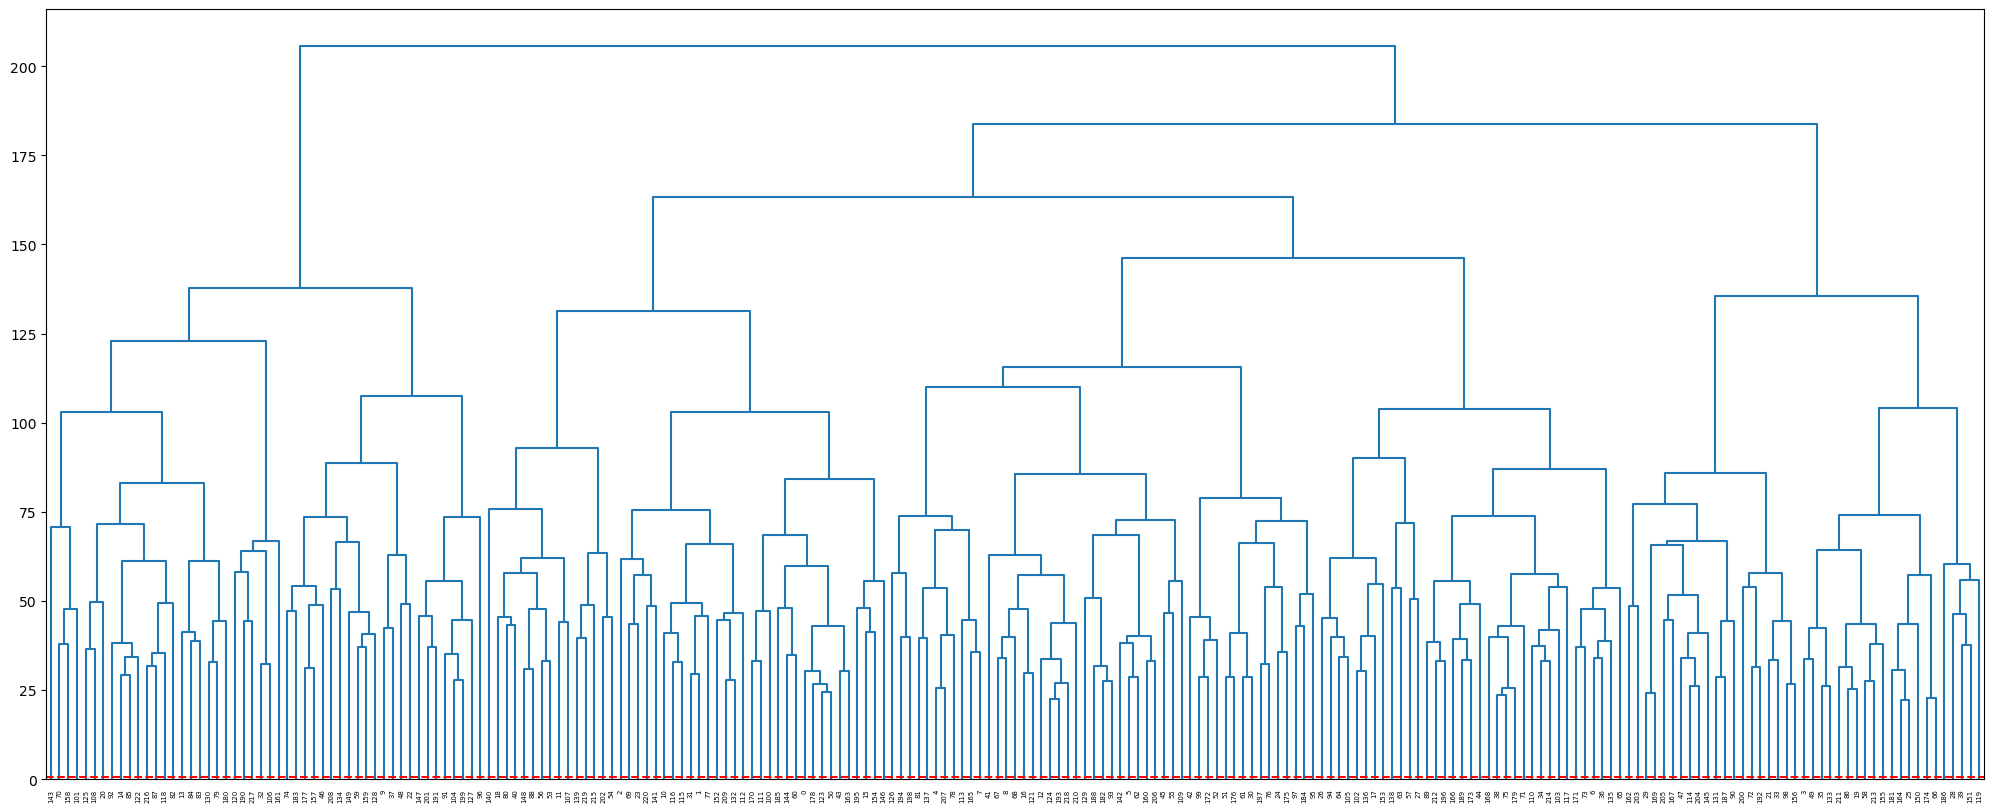

In [73]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

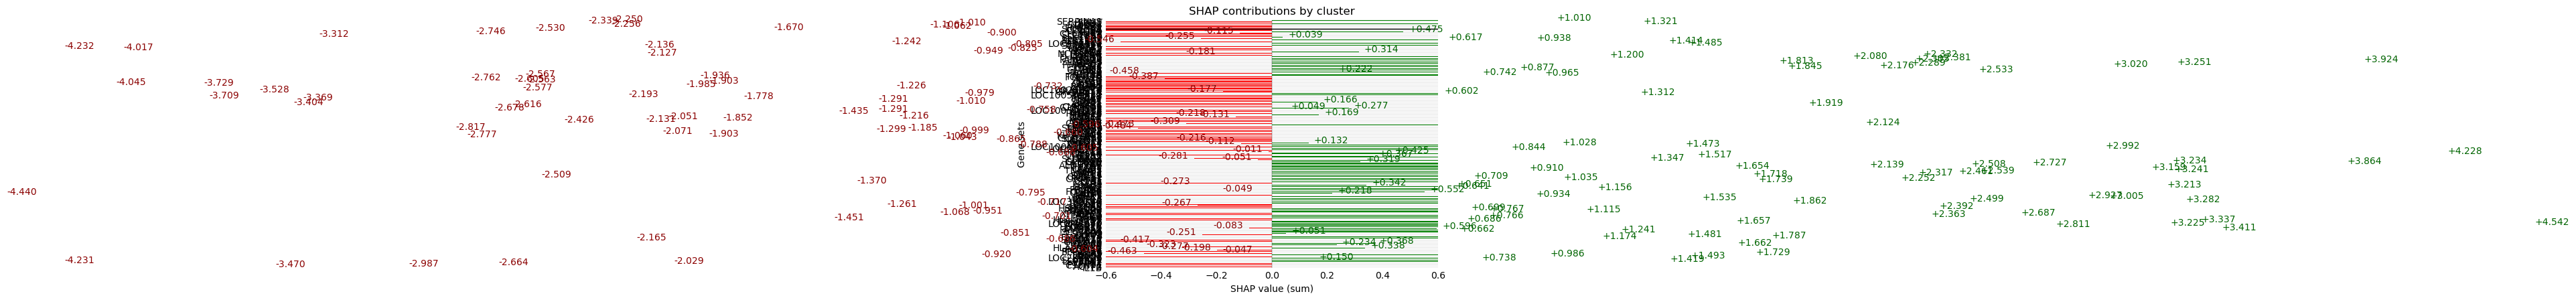

In [74]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [75]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [76]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

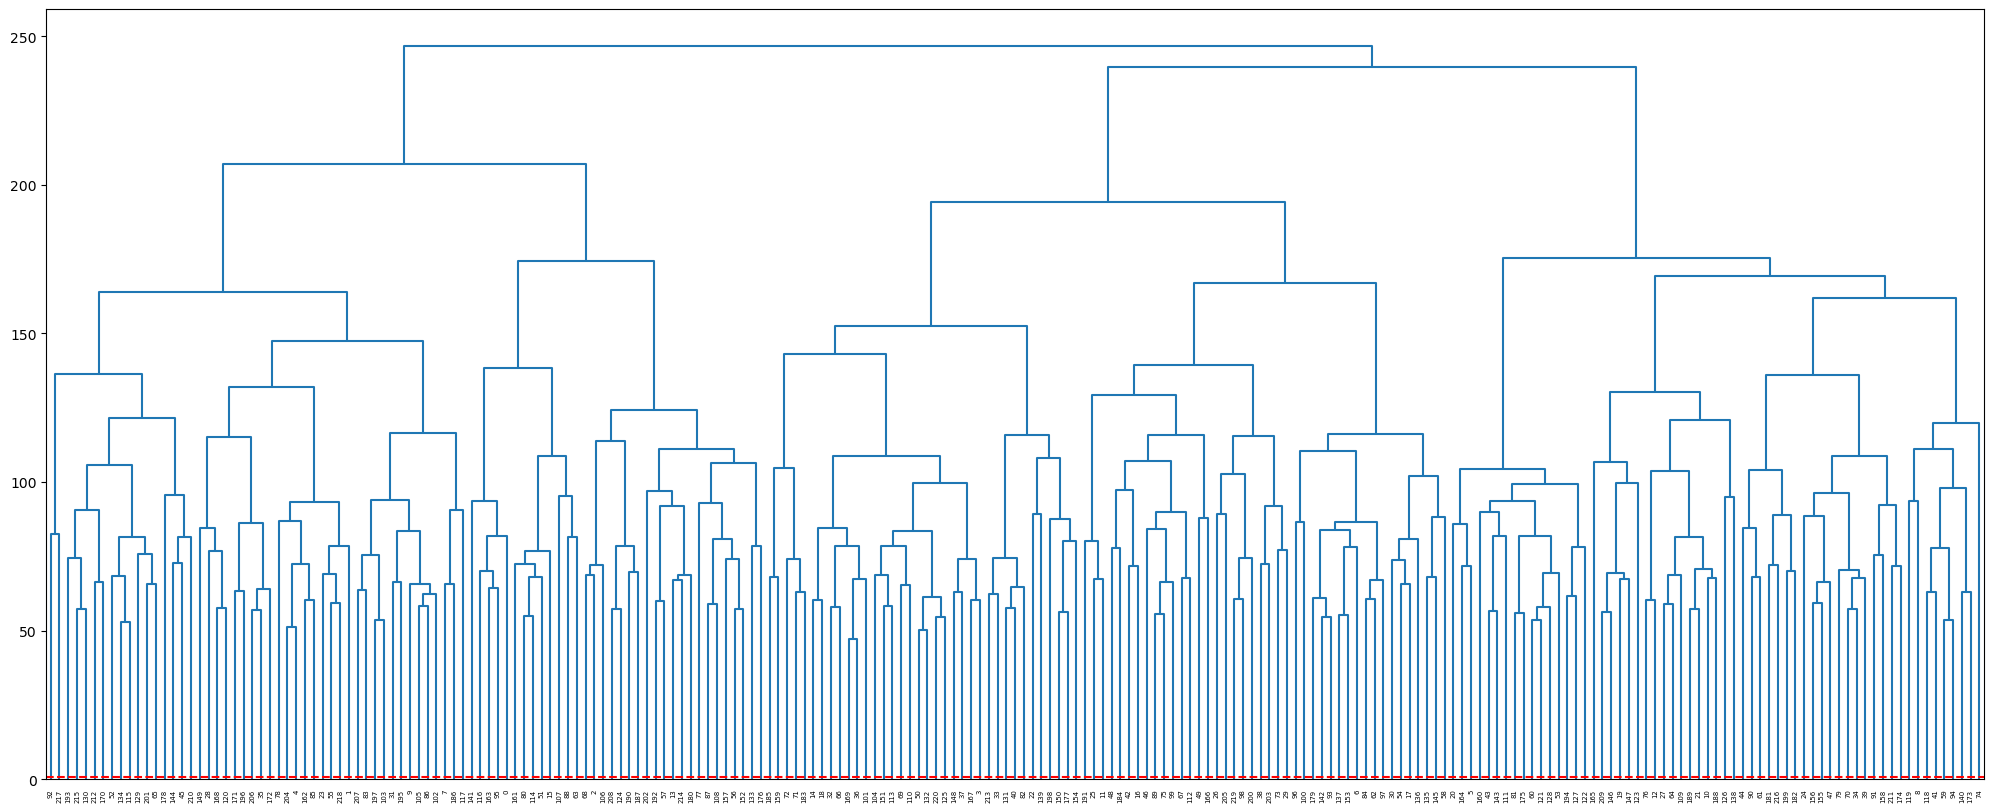

In [77]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [78]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 92, 217, 193, 215, 130, 212, 170,  52, 134, 115, 129, 201,  65,
       178, 144,  45, 210, 149,  28, 168, 120, 171, 196, 206,  35, 172,
        78, 204,   4, 162,  85,  23,  55, 218,   1, 207,  83, 197, 103,
        31, 195,   9, 105,  86, 102,   7, 186, 117, 141, 116, 163,  95,
         0, 161,  80, 114,  51,  15, 107,  88,  63,  68,   2, 106, 208,
       124, 190, 187, 202, 192,  57,  13, 214, 180,  77,  87, 108, 157,
        56, 152, 133, 176, 185, 159,  72,  71, 183,  14,  18,  32,  66,
       169,  36, 101, 104, 151, 113,  69, 110,  50, 132, 220, 125, 148,
        37, 167,   3, 213,  33, 131,  40,  82,  22, 139, 198, 150, 177,
       154, 191,  25,  11,  48, 184,  42,  16,  46,  89,  75,  99,  67,
       112,  49, 166,  26, 205, 219,  98, 200,  38, 203,  73,  29,  96,
       100, 179, 142,  93, 137, 153,   6,  84,  62,  97,  30,  54,  17,
       136, 135, 145,  58,  20, 164,   5, 160,  43, 143, 111,  81, 175,
        60, 121, 128,  53, 194, 127, 122, 165, 209, 146,  19, 14

In [79]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

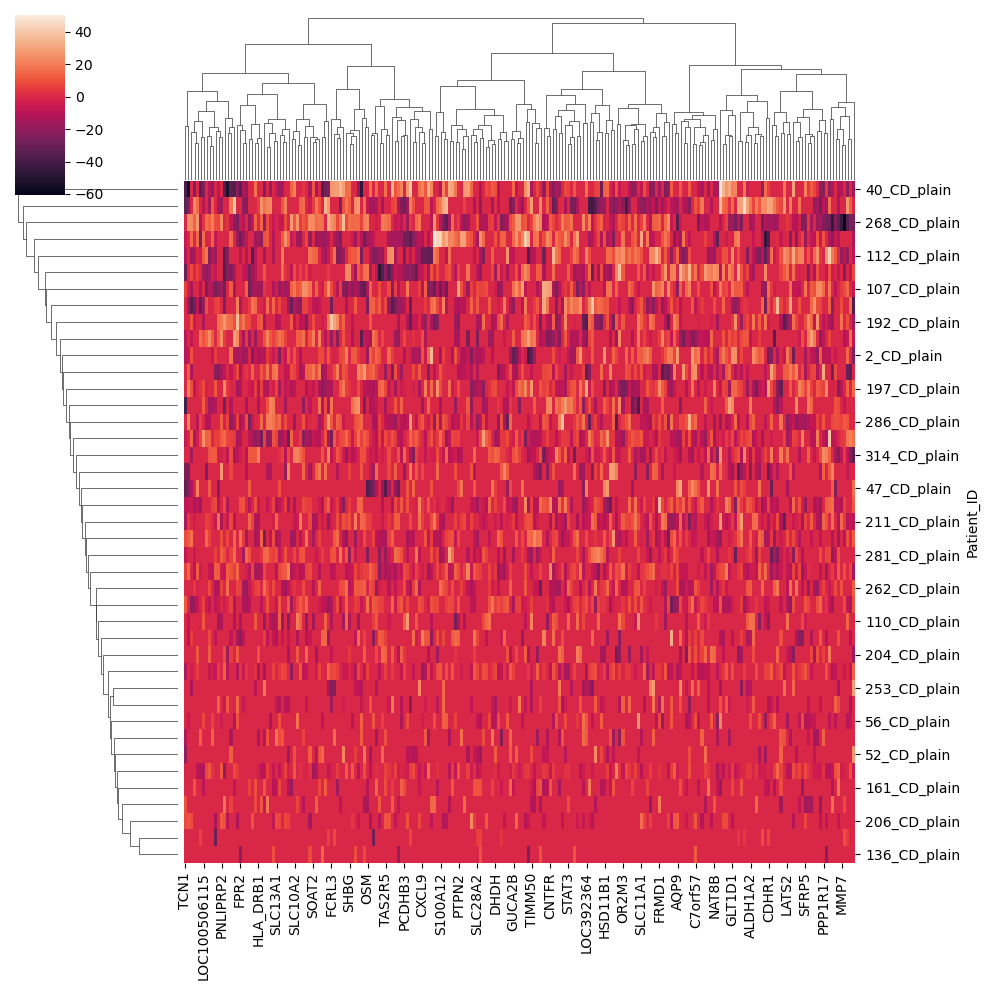

In [80]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [81]:
gene_cluster_cd_plain

array([[169.        ,  36.        ,  47.24302085,   2.        ],
       [ 50.        , 132.        ,  50.27775181,   2.        ],
       [204.        ,   4.        ,  51.04722293,   2.        ],
       [134.        , 115.        ,  52.99085046,   2.        ],
       [197.        , 103.        ,  53.40033988,   2.        ],
       [ 60.        , 121.        ,  53.51370029,   2.        ],
       [ 59.        ,  94.        ,  53.52689165,   2.        ],
       [142.        ,  93.        ,  54.51620095,   2.        ],
       [220.        , 125.        ,  54.69680436,   2.        ],
       [ 80.        , 114.        ,  54.98528765,   2.        ],
       [137.        , 153.        ,  55.11787371,   2.        ],
       [ 89.        ,  75.        ,  55.63104649,   2.        ],
       [ 81.        , 175.        ,  55.92436728,   2.        ],
       [209.        , 146.        ,  56.13262953,   2.        ],
       [150.        , 177.        ,  56.40482934,   2.        ],
       [ 43.        , 143

In [82]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [83]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([ 92, 217, 215, 130, 193, 212, 170, 134, 115,  52, 201,  65, 129,
        144,  45, 210, 178, 168, 120,  28, 149, 171, 196, 206,  35, 172,
        204,   4, 162,  85,  78,  55, 218,  23,   1, 207,  83, 197, 103,
         31, 195, 105,  86, 102,   9,   7, 186, 117, 163,  95, 116,   0,
        141,  80, 114,  51, 161,  15,  88,  63, 107,  68,   2, 106, 208,
        124, 190, 187, 192,  57,  13, 214, 180, 202,  87, 108,  56, 152,
        157,  77, 133, 176, 185, 159,  71, 183,  72,  14,  18,  32,  66,
        169,  36, 101, 151, 113, 104,  69, 110,  50, 132, 220, 125, 148,
         37, 167,   3, 213,  33, 131,  40,  82,  22, 139, 150, 177, 154,
        198,  25,  11, 191,  48, 184,  42,  16,  89,  75,  99,  46,  67,
        112,  49, 166,  26, 205, 219,  98, 200,  38, 203,  73,  29,  96,
        100, 142,  93, 179, 137, 153,   6,  84,  62,  97,  54,  17,  30,
        136, 135, 145,  58, 164,   5,  20,  43, 143, 111, 160,  81, 175,
         60, 121, 128,  53, 194, 127, 122, 209, 146

In [84]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [85]:
cluster_labels

array([ 52,  35,  63, 107,  28, 162, 150,  46, 214,  45, 190, 120, 184,
        71,  88,  58, 125, 155,  89, 179, 163, 189, 113,  34, 204, 119,
       134, 185,  20, 142, 156,  40,  90, 109, 206,  25,  93, 105, 139,
       207, 111, 216, 124, 164, 196,  15, 129, 203, 122, 132, 100,  56,
        10, 173, 154,  32,  77,  70, 160, 217, 170, 195, 152,  60, 186,
        12,  91, 130,  62,  98, 205,  85,  87, 141, 221, 127, 183,  80,
        31, 208,  54, 168, 112,  37, 151,  30,  43,  75,  59, 126, 194,
       209,   1, 146, 218,  50, 143, 153, 137, 128, 144,  94,  44,  39,
        97,  42,  64,  61,  76, 187,  99, 166, 131,  96,  55,   9,  51,
        48, 215, 213,  19, 171, 176, 181,  66, 103, 192, 175, 172,  13,
         4, 110, 101,  81,   8, 158, 157, 148, 193, 114, 219,  53, 145,
       165,  14, 159, 178, 180, 104,  21, 115,  95,  78, 149, 117, 202,
       201,  79, 210,  84, 167,  57,  29,  49, 161, 182, 133, 106,  18,
        92,   7,  22,  26, 220, 212, 169,  82, 116,  17, 147,  7

In [86]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,1.899666,11.586950,-22.293331,0.000000,0.0,8.749370,36.101482,AADAC,52
APOA1,41.0,-2.022095,10.182273,-29.648687,-6.719374,0.0,0.000000,21.652619,APOA1,35
APOA4,41.0,-2.133326,10.817632,-28.433449,-5.293591,0.0,0.000000,17.549485,APOA4,63
APOB,41.0,-0.978330,8.940966,-30.387330,-1.848466,0.0,0.000000,25.997469,APOB,107
APOC3,41.0,0.102131,8.410611,-19.248984,0.000000,0.0,0.000000,22.937687,APOC3,28
...,...,...,...,...,...,...,...,...,...,...
C16orf78,41.0,1.212415,10.810541,-35.414499,0.000000,0.0,0.000000,26.224974,C16orf78,198
C5orf17,41.0,-1.524082,13.699694,-54.499380,-3.182882,0.0,0.000000,24.433359,C5orf17,2
LOC100132831,41.0,-0.009522,9.091399,-20.620540,0.000000,0.0,4.859181,25.455369,LOC100132831,33
LOC100288778,41.0,0.770156,10.368789,-33.797683,0.000000,0.0,5.606484,23.388197,LOC100288778,136


In [87]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,1.899666,52,AADAC
APOA1,-2.022095,35,APOA1
APOA4,-2.133326,63,APOA4
APOB,-0.978330,107,APOB
APOC3,0.102131,28,APOC3
...,...,...,...
C16orf78,1.212415,198,C16orf78
C5orf17,-1.524082,2,C5orf17
LOC100132831,-0.009522,33,LOC100132831
LOC100288778,0.770156,136,LOC100288778


In [88]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,1.899666,52,AADAC
APOA1,-2.022095,35,APOA1
APOA4,-2.133326,63,APOA4
APOB,-0.978330,107,APOB
APOC3,0.102131,28,APOC3
...,...,...,...
C16orf78,1.212415,198,C16orf78
C5orf17,-1.524082,2,C5orf17
LOC100132831,-0.009522,33,LOC100132831
LOC100288778,0.770156,136,LOC100288778


In [89]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-6.527410,1,[TCN1]
2,-1.524082,1,[C5orf17]
3,-2.078391,1,[GUSBP11]
4,1.548931,1,[ATG16L1]
5,-0.937393,1,[FAM127B]
...,...,...,...
217,-1.015392,1,[MMP7]
218,-1.336149,1,[TLR2]
219,-0.449008,1,[BPIFB1]


In [90]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-6.527410,1,[TCN1],TCN1
2,-1.524082,1,[C5orf17],C5orf17
3,-2.078391,1,[GUSBP11],GUSBP11
4,1.548931,1,[ATG16L1],ATG16L1
5,-0.937393,1,[FAM127B],FAM127B
...,...,...,...,...
217,-1.015392,1,[MMP7],MMP7
218,-1.336149,1,[TLR2],TLR2
219,-0.449008,1,[BPIFB1],BPIFB1


In [91]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [92]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-6.527410,1,[TCN1],TCN1
2,-1.524082,1,[C5orf17],C5orf17
5,-2.078391,1,[GUSBP11],GUSBP11
3,1.548931,1,[ATG16L1],ATG16L1
4,-0.937393,1,[FAM127B],FAM127B
...,...,...,...,...
217,-1.015392,1,[MMP7],MMP7
218,-1.336149,1,[TLR2],TLR2
219,-0.449008,1,[BPIFB1],BPIFB1
220,-1.636905,1,[RNF24],RNF24


In [93]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-6.527410,1,[TCN1],TCN1
2,-1.524082,1,[C5orf17],C5orf17
3,1.548931,1,[ATG16L1],ATG16L1
4,-0.937393,1,[FAM127B],FAM127B
5,-2.078391,1,[GUSBP11],GUSBP11
...,...,...,...,...
217,-1.015392,1,[MMP7],MMP7
218,-1.336149,1,[TLR2],TLR2
219,-0.449008,1,[BPIFB1],BPIFB1
220,-1.636905,1,[RNF24],RNF24


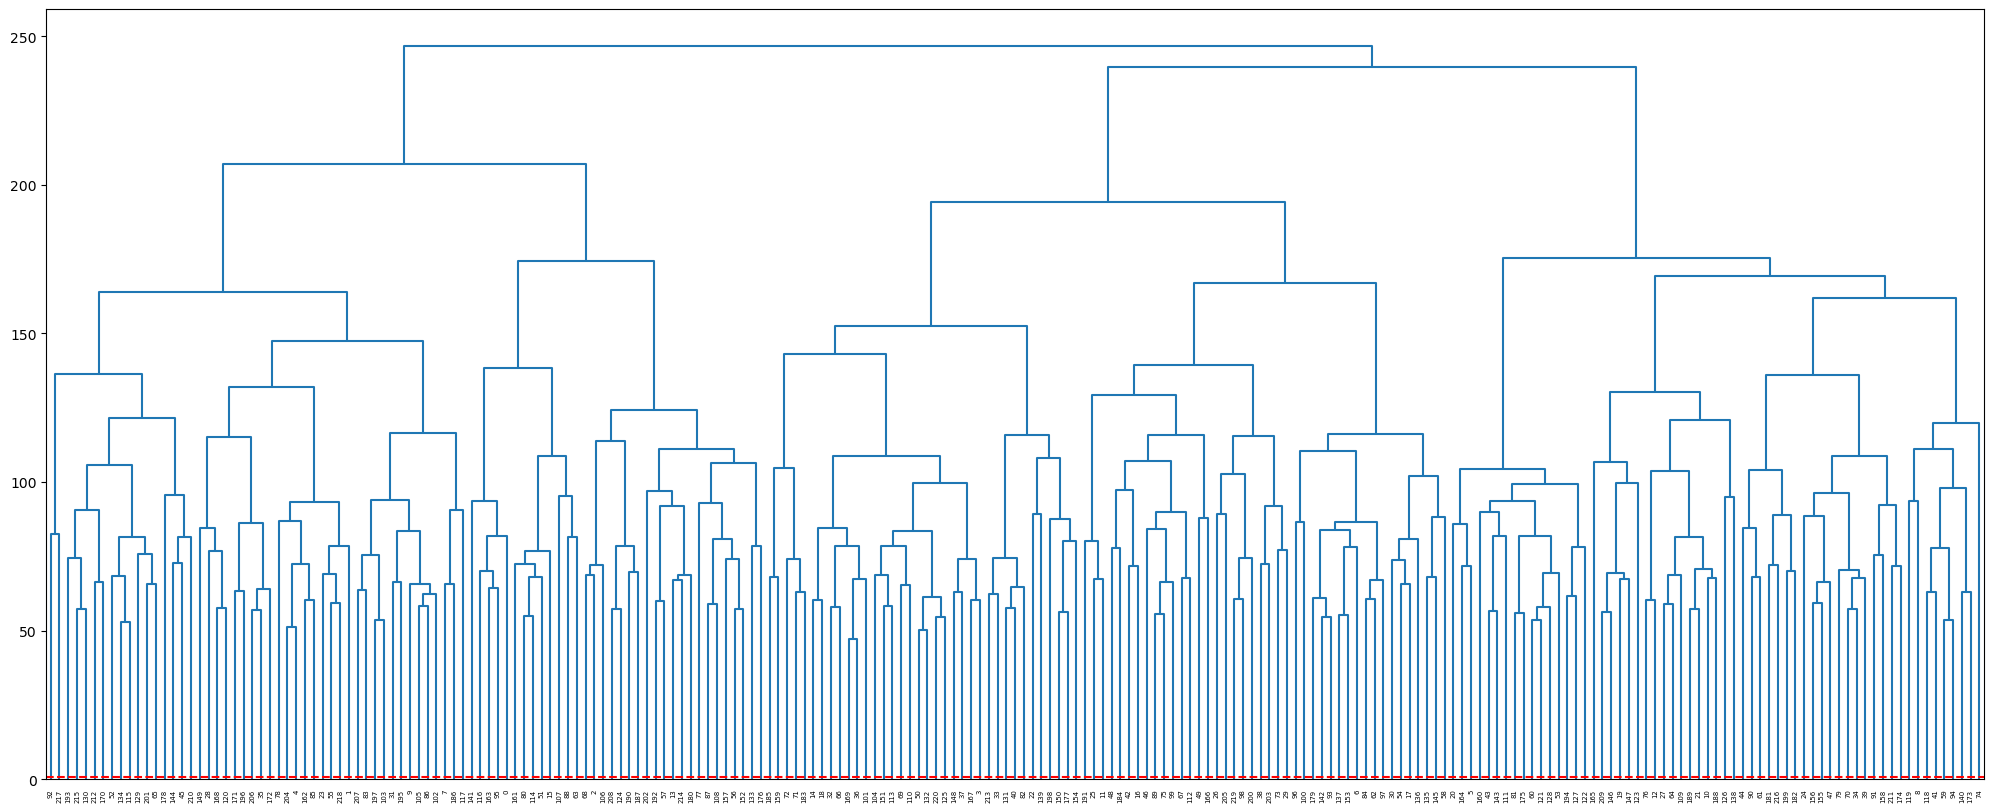

In [94]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

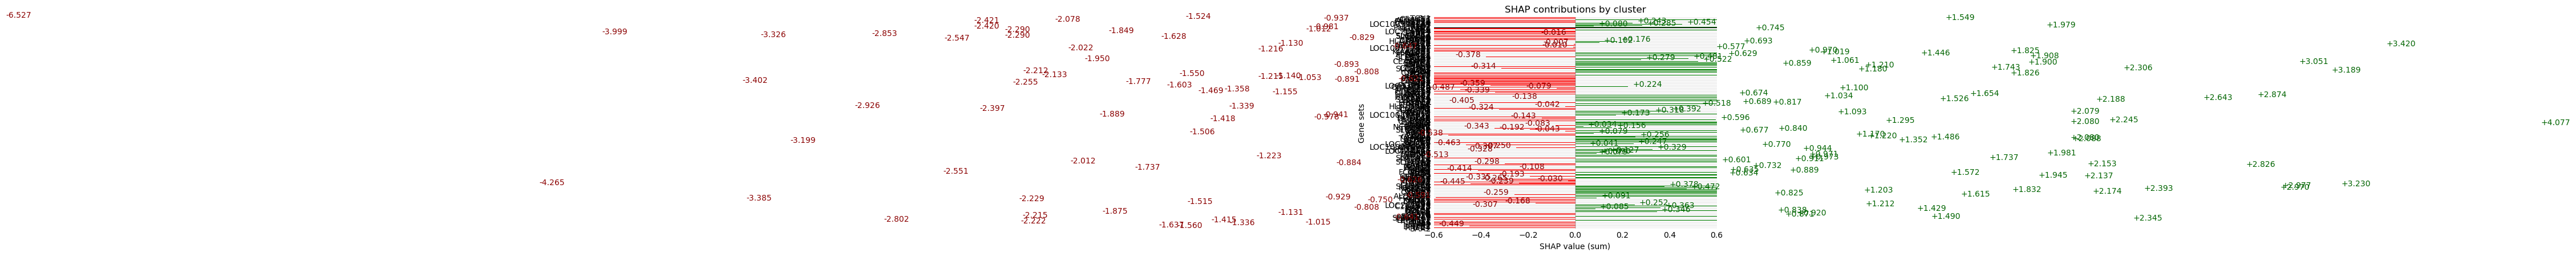

In [95]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [96]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")